### 서울시(중구) 대기오염 예측 10개의 일주일 시간별 데이터로 24시간 예측

In [1]:
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler

### 데이터셋 불러오기 & 정리

In [2]:
df = pd.read_csv("C:\\TF Practice\\total_data_tf.csv")
df.shape

(26279, 11)

In [3]:
df.head()

,Date,Temp,Wspeed,Wdirection,Humidity,PM10,PM2.5,O3,NO2,CO,SO
0,2017-01-01 1:00,0.0,1.4,20.0,78.0,77.0,63.0,0.002,0.068,1.3,0.006
1,2017-01-01 2:00,-0.3,1.9,50.0,81.0,76.0,63.0,0.002,0.066,1.4,0.006
2,2017-01-01 3:00,-0.7,2.0,50.0,84.0,73.0,57.0,0.002,0.063,1.2,0.005
3,2017-01-01 4:00,-1.1,1.6,20.0,85.0,67.0,55.0,0.002,0.053,1.1,0.005
4,2017-01-01 5:00,-1.4,1.4,50.0,86.0,66.0,54.0,0.002,0.051,1.1,0.004


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26279 entries, 0 to 26278
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        26279 non-null  object 
 1   Temp        26274 non-null  float64
 2   Wspeed      26226 non-null  float64
 3   Wdirection  26226 non-null  float64
 4   Humidity    26258 non-null  float64
 5   PM10        26030 non-null  float64
 6   PM2.5       26099 non-null  float64
 7   O3          26039 non-null  float64
 8   NO2         26105 non-null  float64
 9   CO          26109 non-null  float64
 10  SO          26100 non-null  float64
dtypes: float64(10), object(1)
memory usage: 2.2+ MB


In [5]:
date_time = pd.to_datetime(df.pop('Date'), format='%Y-%m-%d %H:%M')

### 풍속 풍향 벡터화

In [6]:
Wv = df.pop('Wspeed')
Wd_rad = df.pop('Wdirection')*np.pi/180
df['Wx'] = Wv*np.cos(Wd_rad)
df['Wy'] = Wv*np.sin(Wd_rad) 

In [7]:
df.index = date_time
df.shape

(26279, 10)

### 누락값 처리

In [8]:
df.isna().sum()

Temp          5
Humidity     21
PM10        249
PM2.5       180
O3          240
NO2         174
CO          170
SO          179
Wx           53
Wy           53
dtype: int64

In [9]:
df_xy=df.interpolate(method='linear', limt_direction='forward')

In [10]:
df_xy.shape

(26279, 10)

### 전처리
- 지난 일주일 간의 기상 데이터로부터 내일 24시간동안의 미세먼지 정도를 예측
- 7일 * 24시간 * 10개 특징 > 1일 * 24시간 * 1개의 대기질 파악
- (7 * 24,4) -> (24)

In [11]:
sequence_X = 24*7
sequence_Y = 24
df_xy.head()

,Temp,Humidity,PM10,PM2.5,O3,NO2,CO,SO,Wx,Wy
Date,,,,,,,,,,
2017-01-01 01:00:00,0.0,78.0,77.0,63.0,0.002,0.068,1.3,0.006,1.315570,0.478828
2017-01-01 02:00:00,-0.3,81.0,76.0,63.0,0.002,0.066,1.4,0.006,1.221296,1.455484
2017-01-01 03:00:00,-0.7,84.0,73.0,57.0,0.002,0.063,1.2,0.005,1.285575,1.532089
2017-01-01 04:00:00,-1.1,85.0,67.0,55.0,0.002,0.053,1.1,0.005,1.503508,0.547232
2017-01-01 05:00:00,-1.4,86.0,66.0,54.0,0.002,0.051,1.1,0.004,0.899903,1.072462


In [12]:
m = len(df_xy) - (sequence_X + sequence_Y) + 1
feature_k = df_xy.shape[-1]
(m, sequence_X, feature_k), (m, sequence_Y), feature_k

((26088, 168, 10), (26088, 24), 10)

In [13]:
data_x = np.zeros((m, sequence_X, feature_k),np.float32)
data_y = np.zeros((m, sequence_Y),np.float32)

In [14]:
data_x.shape,data_y.shape

((26088, 168, 10), (26088, 24))

In [15]:
np.array(df_xy).shape

(26279, 10)

In [16]:
df_arr = np.array(df_xy)
df_arr.shape

(26279, 10)

In [17]:
for i in range(m):
    data_x[i] = df_arr[i:i+sequence_X]

In [18]:
df_test = df_arr[:26279, 2]

In [19]:
df_test.shape

(26279,)

In [20]:
for i in range(m):
    data_y[i] = df_test[i+sequence_X : i+sequence_X+sequence_Y,]

In [21]:
data_x.shape, data_y.shape

((26088, 168, 10), (26088, 24))

### 정규화 (sklearn)

In [23]:
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

In [24]:
data_x_2d = np.reshape(data_x, [-1,feature_k])
scaler_x = scaler_x.fit(data_x_2d)
data_x_2d_normal = scaler_x.transform(data_x_2d)
data_x_normal = np.reshape(data_x_2d_normal, data_x.shape)
data_x_normal.shape, np.min(data_x_normal), np.max(data_x_normal)

((26088, 168, 10), 0.0, 1.0000001)

In [25]:
scaler_y = scaler_y.fit(data_y)
data_y_normal = scaler_y.transform(data_y)
data_y_normal.shape, np.min(data_y_normal), np.max(data_y_normal)

((26088, 24), 0.0, 1.0)

### 학습용/테스트용 분리

In [26]:
m_train = 20000
x_train = data_x_normal[:m_train]
x_test = data_x_normal[m_train:-1]
y_train = data_y_normal[:m_train]
y_test = data_y_normal[m_train:-1]
x_train.shape, x_test.shape, y_train.shape, y_test.shape, 

((20000, 168, 10), (6087, 168, 10), (20000, 24), (6087, 24))

### 모델 구현 및 평가

- 3차원 시계열 데이터 시퀀스 길이 7일 * 24시간 = 168 시간

In [27]:
model = keras.models.Sequential()
model.add(layers.LSTM(128,return_sequences = True))
model.add(layers.LSTM(64,return_sequences = False))
model.add(layers.Dense(24))


In [32]:
output = model(x_train[:5])
output.shape

TensorShape([5, 24])

In [33]:
model.compile(loss='mse',optimizer='adam',metrics=[tf.keras.metrics.RootMeanSquaredError("RMSE")])

In [34]:
model.fit(x_train,y_train, epochs = 30, verbose = 1) 

Epoch 1/30


InternalError:    Failed to call ThenRnnBackward with model config: [rnn_mode, rnn_input_mode, rnn_direction_mode]: 2, 0, 0 , [num_layers, input_size, num_units, dir_count, max_seq_length, batch_size, cell_num_units]: [1, 128, 64, 1, 168, 32, 64] 
	 [[{{node gradients/CudnnRNN_grad/CudnnRNNBackprop}}]]
	 [[PartitionedCall]] [Op:__inference_train_function_9407]

Function call stack:
train_function -> train_function -> train_function


In [68]:
model.evaluate(x_test,y_test)

191/191 [==============================] - 2s 9ms/step - loss: 0.0041 - RMSE: 0.0637


[0.00406177481636405, 0.06373205780982971]

### 예측

In [33]:
pre=model.predict(x_test[:5000])

In [84]:
pre.shape

(5000, 24)

### 예측 및 실제 데이터 그래프 비교

In [85]:
pre_2d=pre.flatten()

In [86]:
pre_2d.shape

(120000,)

In [87]:
pre_2d

array([0.07986704, 0.08598651, 0.08451331, ..., 0.08063126, 0.0790555 ,
       0.07906726], dtype=float32)

In [88]:
y_test.shape

(6087, 24)

In [89]:
y_test_2d = y_test[:5000].flatten()

In [90]:
y_test_2d.shape

(120000,)

In [91]:
y_test_2d

array([0.06143344, 0.04778157, 0.04095563, ..., 0.07849829, 0.10238907,
       0.10921501], dtype=float32)

In [92]:
pre_2d

array([0.07986704, 0.08598651, 0.08451331, ..., 0.08063126, 0.0790555 ,
       0.07906726], dtype=float32)

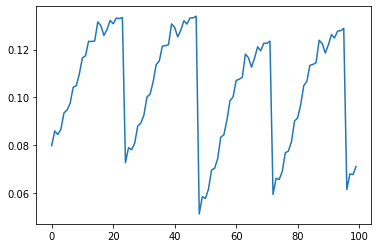

In [96]:
plt.plot(pre_2d[:100])

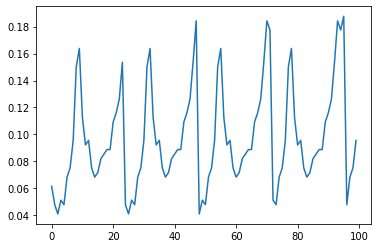

In [95]:
plt.plot(y_test_2d[:100])

In [71]:
pre =model.evaluate(x_test, y_test)

191/191 [==============================] - 2s 8ms/step - loss: 0.0042 - RMSE: 0.0645
